### 4 RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
np.random.seed(42)
import nltk
from nltk.corpus import words
from PIL import Image, ImageDraw, ImageFont

import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(project_root)

#### 4.2 Optical Character Recognition

##### 4.2.1 Task 1: Dataset

In [5]:
nltk.download('words')
word_list = words.words()

import random
# Randomly sample 100k words
dataset_words = random.sample(word_list, 100000)

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
os.makedirs('word_images', exist_ok=True)

# Create a font object
# font = ImageFont.truetype("arial.ttf", 24)
font = ImageFont.load_default()

# Generate images
for idx, word in enumerate(dataset_words):
    img = Image.new('RGB', (256, 64), color = 'white')
    d = ImageDraw.Draw(img)
    # text_width, text_height = d.textsize(word, font=font)
    text_bbox = d.textbbox((0, 0), word, font=font)
    text_x = (256 - (text_bbox[2] - text_bbox[0])) // 2
    text_y = (64 - (text_bbox[3] - text_bbox[1])) // 2
    d.text((text_x, text_y), word, fill='black', font=font)
    img.save(f'word_images/{word}_{idx}.png')

In [7]:
import pandas as pd

# Create a DataFrame with image paths and labels
data = {'image_path': [f'word_images/{word}_{i}.png' for i, word in enumerate(dataset_words)],
        'label': dataset_words}
df = pd.DataFrame(data)

# Save to a CSV file
df.to_csv('word_dataset.csv', index=False)

In [8]:
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('word_dataset.csv')

# Split into train (80%), val (10%), test (10%)
train, test = train_test_split(data, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

# Save the splits
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

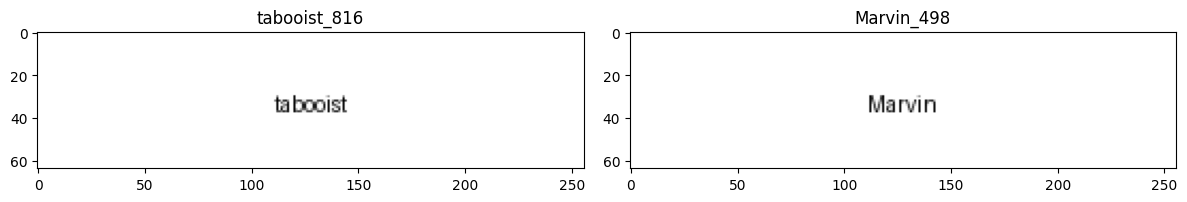

In [9]:
def display_samples(sample_dir, num_samples=2):
    # Get the list of image file paths
    sample_files = os.listdir(sample_dir)
    sample_files = random.sample(sample_files, num_samples)
    
    # Display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i, sample_file in enumerate(sample_files):
        img_path = os.path.join(sample_dir, sample_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis()
        axes[i].set_title(sample_file.split('.')[0])
    plt.tight_layout()
    plt.show()
    
display_samples('word_images')

##### 4.2.2 Task 2: Architecture

In [10]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(0.2)
        )
        
    def forward(self, x):
        x = self.features(x)
        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(batch_size, -1, 256)
        return x
    
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size + input_size, hidden_size, n_layers,
                         batch_first=True, dropout=0.2 if n_layers > 1 else 0)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, encoder_outputs, target, hidden=None):
        batch_size = encoder_outputs.size(0)
        max_length = target.size(1)
        
        outputs = torch.zeros(batch_size, max_length, self.output_size).to(encoder_outputs.device)
        
        embedded = self.embedding(target)
        
        # Initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(1, batch_size, self.hidden_size).to(encoder_outputs.device)
        
        # For each time step
        for t in range(max_length):
            context = encoder_outputs[:, t:t+1, :]
            
            rnn_input = torch.cat((embedded[:, t:t+1, :], context), dim=2)     
            
            output, hidden = self.rnn(rnn_input, hidden)
            
            output = self.out(output.squeeze(1))
            outputs[:, t] = output
            
        return outputs, hidden
    
class OCRModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super(OCRModel, self).__init__()
        self.encoder = CNNEncoder()
        self.decoder = RNNDecoder(input_size=256, hidden_size=hidden_size, output_size=vocab_size)
    
    def forward(self, images, target=None, target_length=None):
        batch_size = images.size(0)
        encoder_outputs = self.encoder(images)
        
        if self.training and target is not None:
            outputs, _ = self.decoder(encoder_outputs, target, hidden=None)
            return outputs
        else:
            # Inference mode
            max_length = target_length.max().item() if target_length is not None else 25  # Maximum sequence length
            outputs = torch.zeros(batch_size, max_length, self.decoder.output_size).to(images.device)
            
            # Initialize with <sos>
            decoder_input = torch.ones(batch_size, 1).long().to(images.device) * 27  # <sos> token
            hidden = None
            
            for t in range(max_length):
                out, hidden = self.decoder(encoder_outputs, decoder_input, hidden)
                outputs[:, t:t+1] = out
                # Get the most likely next character
                _, topi = out.max(2)
                decoder_input = topi.squeeze(-1).unsqueeze(1)
                
                # Stop if all sequences have generated <eos>
                if (decoder_input == 28).all():  # 28 is <eos> token
                    break
            
            return outputs

##### 4.2.3 Task 3: Training

In [11]:
class WordImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, max_length=20):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.max_length = max_length
        
        # Create a character to index mapping
        self.char_to_idx = {chr(i): i-97 for i in range(97, 123)}  # a-z
        self.char_to_idx['<pad>'] = 26
        self.char_to_idx['<sos>'] = 27
        self.char_to_idx['<eos>'] = 28
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['image_path'])
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        # word = self.data.iloc[idx]['label'].lower()

        # # Handle missing or non-string labels
        word = self.data.iloc[idx]['label']
        if not isinstance(word, str):
            word = str(word)
        word = word.lower()

        if self.transform:
            image = self.transform(image)

        # Convert word to indices
        target = [self.char_to_idx['<sos>']]
        target.extend([self.char_to_idx[c] for c in self.char_to_idx])
        # try:
        #     target.extend([self.char_to_idx[c] for c in word if c in self.char_to_idx])
        # except KeyError:
        #     print(f"Encountered unknown character in word: {word}")
        target.append(self.char_to_idx['<eos>'])
        
        length = len(target)
        
        # Pad sequence if necessary
        while length < self.max_length:
            target.extend([self.char_to_idx['<pad>']] * (self.max_length - length))
        else:
            target = target[:self.max_length]
            length = self.max_length
        
        return image, torch.tensor(target), length

In [12]:
def collate_fn(batch):
    """
    Custom collate function to handle variable length sequences
    """
    # Sort batch by sequence length (descending)
    batch.sort(key=lambda x: x[2], reverse=True)
    
    # Separate images, targets, and lengths
    images, targets, lengths = zip(*batch)
    
    # Stack images
    images = torch.stack(images, 0)
    
    # Pad and stack targets
    targets = torch.stack(targets, 0)
    
    # Convert lengths to tensor
    lengths = torch.tensor(lengths)
    
    return images, targets, lengths

def setup_training(batch_size=32):
    """
    Set up datasets and dataloaders for training
    """
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((64, 256)),
        transforms.ToTensor(),
    ])

    img_dir = '/kaggle/working/'
    # Create datasets
    train_dataset = WordImageDataset('train.csv', img_dir, transform=transform)
    val_dataset = WordImageDataset('val.csv', img_dir, transform=transform)
    test_dataset = WordImageDataset('test.csv',img_dir,transform=transform)

    # Create dataloaders with custom collate function
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [13]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct_chars = 0
    total_chars = 0
    
    for batch_idx, (images, targets, lengths) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, targets, lengths)
        
        # Reshape outputs and targets for loss calculation
        batch_size = outputs.size(0)
        outputs = outputs.view(-1, outputs.size(2))
        targets = targets.view(-1)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        pred = outputs.argmax(dim=1)
        mask = targets != 26  # Ignore padding token
        correct_chars += ((pred == targets) & mask).sum().item()
        total_chars += mask.sum().item()
        
        # if batch_idx % 100 == 0:
        #     print(f'Batch {batch_idx}: Loss {loss.item():.4f}, Acc {correct_chars/total_chars:.4f}')
        
    return total_loss / len(train_loader), correct_chars / total_chars

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_chars = 0
    total_chars = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets, lengths) in enumerate(val_loader):

            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images, targets, lengths)
            # outputs = model(images, target=None, target_length=lengths)

            # Reshape outputs and targets for loss calculation
            batch_size = outputs.size(0)
            outputs = outputs.view(-1, outputs.size(2))
            targets = targets.view(-1)
                    
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Calculate accuracy
            pred = outputs.argmax(dim=1)
            mask = targets != 26  # Ignore padding token
            correct_chars += ((pred == targets) & mask).sum().item()
            total_chars += mask.sum().item()
            
            # # Calculate accuracy
            # pred = outputs.argmax(dim=1)
            # correct_chars += (pred == targets).sum().item()
            # total_chars += targets.size(0)
    
    return total_loss / len(val_loader), correct_chars / total_chars

In [14]:
# Main training loop
def train_model(model, train_loader, val_loader, num_epochs=5, device='cuda'):
    criterion = nn.CrossEntropyLoss(ignore_index=26)  # ignore padding index
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    best_val_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

In [15]:
# project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup data loaders
train_loader, val_loader, test_loader = setup_training()

In [27]:
# Initialize model
model = OCRModel(vocab_size=29).to(device)

# Train model
train_model(model, train_loader, val_loader, device=device)

Epoch 1/5:
Train Loss: 0.6465, Train Acc: 0.9194
Val Loss: 0.0005, Val Acc: 0.9090
Epoch 2/5:
Train Loss: 0.0067, Train Acc: 1.0000
Val Loss: 0.0002, Val Acc: 0.9999
Epoch 3/5:
Train Loss: 0.0035, Train Acc: 1.0000
Val Loss: 0.0001, Val Acc: 1.0000
Epoch 4/5:
Train Loss: 0.0027, Train Acc: 1.0000
Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/5:
Train Loss: 0.0024, Train Acc: 1.0000
Val Loss: 0.0000, Val Acc: 1.0000


In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=26)
test_loss, test_accuracy = validate(model,test_loader,criterion,device)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.9998


In [35]:
def generate_random_baseline(batch_size, max_length, num_classes):
    return torch.randint(1, num_classes, (batch_size, max_length))

In [39]:
# Find average number of correct characters on test set using random baseline
total_correct = 0
total_characters = 0

for images, labels, _ in test_loader:
    true_word = labels[0]  # Flatten the true word
    pred = generate_random_baseline(1, true_word.size(0), num_classes=27)  # Random prediction
    correct_characters = (true_word == pred).sum().item()
    total_correct += correct_characters
    total_characters += len(true_word)

random_baseline_accuracy = total_correct / total_characters if total_characters > 0 else 0
print(f"Random Baseline Accuracy: {random_baseline_accuracy:.4f}")

Random Baseline Accuracy: 0.0125
